In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import sklearn

from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn import FunctionSampler  # to use a idendity sampler

from pandas.api.types import CategoricalDtype

In [2]:
np.random.seed(0)
IMPUTATION_REQUIRED=0
TRAIN_SIZE=0.8
PAR_NORMALIZE=0
PAR_SCALE=1
target_col = 'lrgen' # 'lrgen', 'lrecon', 'galtan'
target_factor = target_col + '_factor' # 'lrgen_factor', 'lrecon_factor', 'galtan_factor'
SOURCE_DATA_FILES = 'data/imputed_data/recategorized/imputation_cart/'
FILE_SUFFIX = '_recategorized'

In [3]:
#data_raw = pd.read_csv("data/CHES2019_experts_imputed_cart.csv", index_col=0).reset_index(drop=True)
data_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_train' + FILE_SUFFIX + '.csv', index_col = 0)
data_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_train' + FILE_SUFFIX + '.csv', index_col = 0)
valid_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_valid' + FILE_SUFFIX + '.csv', index_col = 0)
valid_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_valid' + FILE_SUFFIX + '.csv', index_col = 0)
test_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_test' + FILE_SUFFIX + '.csv', index_col = 0)
test_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_test' + FILE_SUFFIX + '.csv', index_col = 0)
#data = pd.read_csv("data/CHES2019_experts_imputed_pmm.csv")

In [4]:
# combination allowed
data_X = data_X.append(valid_X)
data_y = data_y.append(valid_y)

In [5]:
data_raw = data_X.merge(data_y, left_on = data_X.index, right_on = data_y.index, how = 'right').set_index('key_0')

In [6]:
data_raw

,econ_interven,environment,redistribution,civlib_laworder,immigrate_policy,sociallifestyle,lrgen_factor
key_0,,,,,,,
1789,10,6,8,10,10,9,r
778,8,6,7,7,7,4,n
1745,5,7,3,6,5,3,n
1938,7,6,6,6,6,2,n
3656,5,5,5,6,9,5,n
...,...,...,...,...,...,...,...
1164,3,5,0,7,7,9,r
1461,7,7,4,7,8,9,r
1151,4,5,3,5,7,5,n


In [7]:
# imputation and preprocessing (if required)
#if (IMPUTATION_REQUIRED==1):
#    numeric_features = data.columns.values[0:6]
#    numeric_transformer = Pipeline(steps=[
#        ("imputer", SimpleImputer(strategy="mean")),
#        ("scaler", StandardScaler())
#    ])
#
#    categorical_features = ["lrgen_factor", "lrecon_factor", "galtan_factor"]
#    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
#
#    preprocessor = ColumnTransformer(transformers=[
#        ("num_transform", numeric_transformer, numeric_features),
#        ("cat_transform", categorical_transformer, categorical_features)
#    ])


In [8]:
data_raw.describe()

,econ_interven,environment,redistribution,civlib_laworder,immigrate_policy,sociallifestyle
count,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000
mean,4.560079,5.210112,4.437295,5.128365,5.602758,4.416612
std,2.636145,2.613815,2.547643,2.921345,2.925082,3.253510
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000
50%,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000
75%,6.000000,7.000000,6.000000,7.750000,8.000000,7.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [9]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3046 entries, 1789 to 2164
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   econ_interven     3046 non-null   int64 
 1   environment       3046 non-null   int64 
 2   redistribution    3046 non-null   int64 
 3   civlib_laworder   3046 non-null   int64 
 4   immigrate_policy  3046 non-null   int64 
 5   sociallifestyle   3046 non-null   int64 
 6   lrgen_factor      3046 non-null   object
dtypes: int64(6), object(1)
memory usage: 190.4+ KB


# Data preprocessing
Preprocessing steps (after imputation in R)

In [10]:
# split data into training and test dataset
# split data for obtaining a separated TEST dataset (not used for training)
X, y = data_raw[data_raw.columns.values[0:6]], data_raw[data_raw.columns.values[6]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=TRAIN_SIZE)

In [11]:
# standardization/normalization of data
# Be aware: information related to scaling MUST NOT flow into the separated datasets
# --> 1st split, 2nd scaling
if (PAR_NORMALIZE==1):
    data_normalized = preprocessing.normalize(X_train)

if (PAR_SCALE==1):
    scaler = preprocessing.StandardScaler().fit(X_train)
    data_scaled = scaler.transform(X_train)

In [12]:
X_train_base = X_train
y_train_base = y_train

# Oversampling to balance the dataset regarding target variable

In [13]:
#samplers = [
#    FunctionSampler(),
#    RandomOverSampler(random_state=0),
#    SMOTE(random_state=0),
#    ADASYN(random_state=0),
#]


#X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train_base, y_train_base)
X_train, y_train = SMOTE(random_state=0, sampling_strategy='not majority').fit_resample(X_train_base, y_train_base)
#X_train, y_train = ADASYN(random_state=0, sampling_strategy='minority').fit_resample(X_train_base, y_train_base)


#for sampler in samplers:
#    sampler.fit_resample(X_train, y_train)




In [14]:
y_train.value_counts()

l    1471
n    1471
r    1471
Name: lrgen_factor, dtype: int64

# Principal Component Analysis: reduce dimensionality

In [15]:
# create a PCA with 2 components
# combine the result with the target result
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 
                                        'PC2'],
                          index=X_train.index)
finalDf = pd.concat([principalDf, y_train], axis = 1)


In [16]:
finalDf[target_factor].factorize()[0]

array([0, 1, 1, ..., 2, 2, 2])

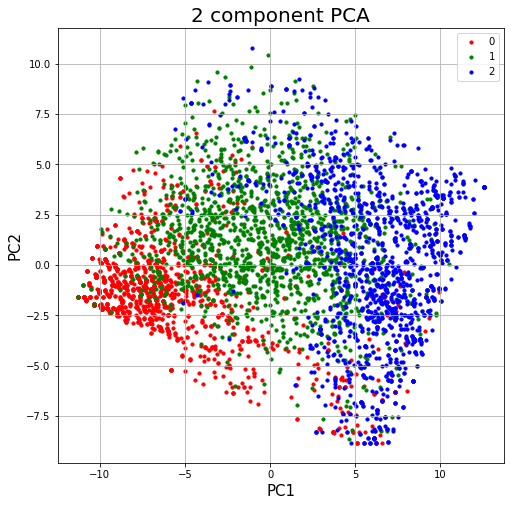

In [17]:
# visualize the results of the PCA
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = range(0,3)
colors = ['r', 'g', 'b']#, 'c',  'm',  'y',  'k',  'gray',  'lime',  'orange',  'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[target_factor].factorize()[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

In [18]:
# about 80% of the variance are explained through the 2 components
pca.explained_variance_ratio_

array([0.65817224, 0.18647293])

# Clustering
Check if some patterns can be observed using unsupervised learning

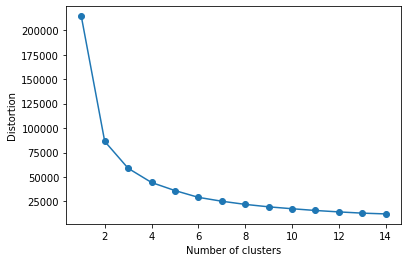

In [19]:
# try to obtain best number of clusters through scree plot
distortions = []
for i in range(1, 15):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(finalDf[['PC1', 'PC2']])
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [20]:
# try to cluster results of PCA
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(finalDf[['PC1', 'PC2']])

In [21]:
y_km

array([3, 3, 1, ..., 3, 1, 1], dtype=int32)

In [22]:
cluster_data = pd.concat([finalDf, 
                          pd.DataFrame(y_km, 
                                       index=X_train.index, 
                                       columns=['cluster'])], 
                         axis=1)

In [23]:
cluster_data.head(20)
#cluster_data[cluster_data['lrgen_factor']==10]['cluster'].value_counts()

,PC1,PC2,lrgen_factor,cluster
0,2.226259,-0.544813,l,3
1,0.692490,-0.598628,n,3
2,3.979721,0.465235,n,1
3,-1.148147,2.881004,n,3
4,5.316996,-6.821882,r,2
5,1.707055,-4.151195,l,2
6,-4.336553,6.368666,n,3
7,-4.579408,-1.181487,n,0
8,5.705549,-1.363176,n,2
9,2.946371,0.037761,n,3


# Supervised learning: various algorithms
### Sources: https://vitalflux.com/grid-search-explained-python-sklearn-examples/

## 1) Support Vector Classification

CHECK: RMSE and other scoring mechanisms

In [24]:
########### PARAMETERS 
scoring_method = 'balanced_accuracy'#['balanced_accuracy', 'f1_samples', 'roc_auc_ovo_weighted']

In [25]:
# CROSS-VALIDATION (without TEST dataset)

clf = SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.7587769  0.78369196 0.78822197 0.76870748 0.77891156]
0.78 accuracy with a standard deviation of 0.01


In [26]:
pipelineSVC = make_pipeline(StandardScaler(), SVC(random_state=1))
# Create the parameter grid
param_grid_svc = [{
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['linear'],
                    'svc__degree': [1,2,3,4,5]
                  },
                 {
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['rbf']
                 }]
# Create an instance of GridSearch Cross-validation estimator
gsSVC = GridSearchCV(estimator=pipelineSVC,
                     param_grid = param_grid_svc,
                     scoring=scoring_method,
                     cv=10,
                     refit=True,
                     n_jobs=1)
# Train the SVM classifier
gsSVC.fit(X_train, y_train)
# Print the training score of the best model
print(gsSVC.best_score_)
# Print the model parameters of the best model
print(gsSVC.best_params_)
# Print the model score on the test data using GridSearchCV score method
print('Test accuracy: %.3f' % gsSVC.score(X_test, y_test))
# Print the model score on the test data using Best estimator instance
clfSVC = gsSVC.best_estimator_
print('Test accuracy: %.3f' % clfSVC.score(X_test, y_test))

0.8649782435496721
{'svc__C': 10.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}
Test accuracy: 0.709
Test accuracy: 0.713


## Random Forest Classification

In [27]:
pipelineRFC = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1, criterion='entropy')) 
# Create the parameter grid
                            
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6],
    'randomforestclassifier__n_estimators':range(5, 105, 5)#,
    #'randomforestclassifier__criterion:':['gini', 'entropy']
}]
# Create an instance of GridSearch Cross-validation estimator
gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring=scoring_method,
                     cv=10,
                     refit=True,
                     n_jobs=1)
# Train the RandomForestClassifier
gsRFC = gsRFC.fit(X_train, y_train)
# Print the training score of the best model
print(gsRFC.best_score_)
# Print the model parameters of the best model
print(gsRFC.best_params_)
# Print the test score of the best model
clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test, y_test))

0.8679123000551572
{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__n_estimators': 55}
Test accuracy: 0.772


In [28]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

## Logistic Regression Classification

In [29]:
pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))
# Create the parameter grid
param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
}]
# Create an instance of GridSearch Cross-validation estimator
gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring=scoring_method,
                     cv=10,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsLR = gsLR.fit(X_train, y_train)
# Print the training score of the best model
print(gsLR.best_score_)
# Print the model parameters of the best model
print(gsLR.best_params_)
# Print the test score of the best model
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))

0.7793068578782865
{'logisticregression__C': 0.05}
Test accuracy: 0.721


## ADABoost Classification (Ensemble Method)

In [30]:
pipelineADAB = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))
# Create the parameter grid
param_grid_ADAB = [{
    'adaboostclassifier__n_estimators': [2, 10, 20, 30, 40, 50, 100]
}]
# Create an instance of GridSearch Cross-validation estimator
gsADAB = GridSearchCV(estimator=pipelineADAB,
                     param_grid = param_grid_ADAB,
                     scoring=scoring_method,
                     cv=10,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsADAB = gsADAB.fit(X_train, y_train)
# Print the training score of the best model
print(gsADAB.best_score_)
# Print the model parameters of the best model
print(gsADAB.best_params_)
# Print the test score of the best model
clfADAB = gsADAB.best_estimator_
print('Test accuracy: %.3f' % clfADAB.score(X_test, y_test))

0.7813446099160386
{'adaboostclassifier__n_estimators': 40}
Test accuracy: 0.718


In [31]:
gsADAB.scoring

'balanced_accuracy'

# Test models with independent dataset

In [32]:
#scaler = preprocessing.StandardScaler().fit(test_X)
#test_X_scaled = scaler.transform(test_X)

In [33]:
sklearn.metrics.accuracy_score(test_y, gsADAB.predict(test_X))

0.7138643067846607

In [34]:
sklearn.metrics.confusion_matrix(test_y, gsADAB.predict(test_X))

array([[ 43,   9,   2],
       [ 36, 135,  43],
       [  3,   4,  64]])

In [35]:
sklearn.metrics.accuracy_score(test_y, gsLR.predict(test_X))

0.7640117994100295

In [36]:
sklearn.metrics.confusion_matrix(test_y, gsLR.predict(test_X))

array([[ 46,   7,   1],
       [ 33, 146,  35],
       [  0,   4,  67]])

In [37]:
sklearn.metrics.accuracy_score(test_y, gsRFC.predict(test_X))

0.8053097345132744

In [38]:
sklearn.metrics.confusion_matrix(test_y, gsRFC.predict(test_X))

array([[ 42,  10,   2],
       [ 19, 171,  24],
       [  0,  11,  60]])

In [39]:
sklearn.metrics.accuracy_score(test_y, gsSVC.predict(test_X))

0.7787610619469026

In [40]:
sklearn.metrics.confusion_matrix(test_y, gsSVC.predict(test_X))

array([[ 40,  13,   1],
       [ 22, 169,  23],
       [  1,  15,  55]])

In [41]:
#pipeline = Pipeline(steps=[("preprocesser", preprocessor), ("classifier", LogisticRegression())])
#pipeline.fit(X_train, y_train)

In [42]:
#pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [43]:
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
#pipe.fit(X_train, y_train)
#Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
#pipe.score(X_test, y_test)

In [44]:
### Write several scores to the output ###

RMSE = False
model_vector = [gsADAB, gsLR, gsRFC, gsSVC]
for model in model_vector:
    print(model.estimator.named_steps)
    print('Accuracy Score: ', sklearn.metrics.accuracy_score(test_y, model.predict(test_X)))
    print('Balanced Accuracy Score: ', sklearn.metrics.balanced_accuracy_score(test_y, model.predict(test_X)))
    print('Cohen-Kappa-Score: ', sklearn.metrics.cohen_kappa_score(test_y, model.predict(test_X)))
    print('F1-Score: ', sklearn.metrics.f1_score(test_y, model.predict(test_X), average='weighted'))
    if RMSE == True:
        print('RMSE: ', sklearn.metrics.mean_squared_error(test_y, model.predict(test_X)))
        #print('ROC-AUC-Score: ', sklearn.metrics.roc_auc_score(test_y, 
        #                                                       model.predict(test_X), 
        #                                                       average='weighted', 
        #                                                       multi_class='ovo'))
    print('__________________________________\n')

for model in model_vector:
    print('Confusion matrix: \n', sklearn.metrics.confusion_matrix(test_y, model.predict(test_X)))

for model in model_vector:
    print(sklearn.metrics.classification_report(test_y, model.predict(test_X)))

{'standardscaler': StandardScaler(), 'adaboostclassifier': AdaBoostClassifier(random_state=1)}
Accuracy Score:  0.7138643067846607
Balanced Accuracy Score:  0.7761819561652828
Cohen-Kappa-Score:  0.5373934329366084
F1-Score:  0.7204991368168926
__________________________________

{'standardscaler': StandardScaler(), 'logisticregression': LogisticRegression(random_state=1)}
Accuracy Score:  0.7640117994100295
Balanced Accuracy Score:  0.8259189381123478
Cohen-Kappa-Score:  0.6111493461803166
F1-Score:  0.7683268767685785
__________________________________

{'standardscaler': StandardScaler(), 'randomforestclassifier': RandomForestClassifier(criterion='entropy', random_state=1)}
Accuracy Score:  0.8053097345132744
Balanced Accuracy Score:  0.8073045402912454
Cohen-Kappa-Score:  0.6527555755591079
F1-Score:  0.808191752320511
__________________________________

{'standardscaler': StandardScaler(), 'svc': SVC(random_state=1)}
Accuracy Score:  0.7787610619469026
Balanced Accuracy Score:  0.

In [45]:
print('Features:           ', gsRFC.feature_names_in_)
print('Feature Importance: ', gsRFC.best_estimator_[1].feature_importances_)

Features:            ['econ_interven' 'environment' 'redistribution' 'civlib_laworder'
 'immigrate_policy' 'sociallifestyle']
Feature Importance:  [0.1963586  0.07820629 0.24142569 0.1815855  0.19180724 0.11061668]


In [46]:
import dill
dill.dump_session('notebook_env_1.db')

#Restore a Notebook session:

#dill.load_session('notebook_env_1.db')


PicklingError: Can't pickle <function _make_type_validator.<locals>.validate_int at 0x7f2e24e5ca70>: it's not found as matplotlib.rcsetup._make_type_validator.<locals>.validate_int